# MissOh DataLoader

### AnotherMissOh Visual Structure
- json_data['file_name'] : 'AnotherMissOh01.mp4'
- json_data['visual_results']
- json_data['visual_results'][0].keys() : dict_keys(['start_time', 'end_time', 'vid', 'image_info'])
- {
'start_time': '00:02:51;16', 
'end_time': '00:02:54;15', 
'vid': 'AnotherMissOh01_001_0078', 
'image_info': ...}
- json_data['visual_results'][0]['image_info']
- [{'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004295', 
'place': 'none', 
'persons': [
{'person_id': 'Haeyoung1', 
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 845, 'max_y': 443}, 
'full_rect': {'min_x': 278, 'min_y': 2, 'max_x': 1025, 'max_y': 769}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}], 
'objects': []}, 
- {'frame_id': 'AnotherMissOh01_001_0078_IMAGE_0000004311', 
'place': '', 
'persons': [{
'person_id':'Haeyoung1',
'person_info': {
'face_rect': {'min_x': 515, 'min_y': 0, 'max_x': 831, 'max_y': 411}, 
'full_rect': {'min_x': 270, 'min_y': 0, 'max_x': 1025, 'max_y': 768}, 
'behavior': 'stand up', 
'predicate': 'none', 
'emotion': 'Neutral', 
'face_rect_score': '0.5', 
'full_rect_score': '0.9'}, 
'related_objects': []}],
'objects': []},]

In [3]:
# !apt-get install graphviz xdg-utils

In [4]:
import sys, os
sys.path.append("../") # go to parent dir

In [5]:
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import pickle
import numpy as np
import glob
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import json
import argparse
import matplotlib.pyplot as plt

from Yolo_v2_pytorch.src.utils import *
from graphviz import Digraph, Graph

In [6]:
def is_not_blank(s):
    return bool(s and s.strip())

In [7]:
MissOh_CLASSES = ['person']
print(MissOh_CLASSES[0])
global colors
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))
print(colors[0])

person
(39, 129, 113)


In [8]:
import sys, os
sys.path.append("../") # go to parent dir

In [9]:
import os
import glob
import argparse
import pickle
import cv2
import numpy as np
from Yolo_v2_pytorch.src.utils import *
import torch.nn.functional as F
from torch.utils.data import DataLoader
from Yolo_v2_pytorch.src.yolo_net import Yolo
from Yolo_v2_pytorch.src.anotherMissOh_dataset import AnotherMissOh, Splits, SortFullRect, PersonCLS,PBeHavCLS, FaceCLS, ObjectCLS, P2ORelCLS
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import time

from lib.place_model import place_model, label_mapping, accuracy, label_remapping, place_buffer
from lib.person_model import person_model
from lib.behavior_model import behavior_model
from lib.pytorch_misc import optimistic_restore, de_chunkize, clip_grad_norm, flatten
from lib.focal_loss import FocalLossWithOneHot, FocalLossWithOutOneHot, CELossWithOutOneHot
from lib.face_model import face_model
from lib.object_model import object_model
from lib.relation_model import relation_model
from lib.emotion_model import emotion_model, crop_face_emotion, EmoCLS

num_persons = len(PersonCLS)
num_behaviors = len(PBeHavCLS)
num_faces = len(FaceCLS)
num_objects = len(ObjectCLS)
num_relations = len(P2ORelCLS)
num_emos = len(EmoCLS)

def get_args():
    parser = argparse.ArgumentParser(
        "You Only Look Once: Unified, Real-Time Object Detection")
    parser.add_argument("--image_size",
                        type=int, default=448,
                        help="The common width and height for all images")
    parser.add_argument("--batch_size", type=int, default=1,
                        help="The number of images per batch")
    parser.add_argument("--conf_threshold",
                        type=float, default=0.35)
    parser.add_argument("--nms_threshold",
                        type=float, default=0.5)
    parser.add_argument("--pre_trained_model_type",
                        type=str, choices=["model", "params"],
                        default="model")
    parser.add_argument("--data_path_test",
                        type=str,
                        default="./Yolo_v2_pytorch/missoh_test/",
                        help="the root folder of dataset")

    parser.add_argument("--saved_path", type=str,
                        default="./checkpoint/refined_models")

    parser.add_argument("--img_path", type=str,
                        default="./data/AnotherMissOh/AnotherMissOh_images_ver3.2/")
    parser.add_argument("--json_path", type=str,
                        default="./data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/")
    parser.add_argument("-model", dest='model', type=str, default="baseline")
    parser.add_argument("-display", dest='display', action='store_true')
    parser.add_argument("-emo_net_ch", dest='emo_net_ch',type=int, default=64)
    args = parser.parse_args([])
    return args

# get args.
opt = get_args()
print(opt)

Namespace(batch_size=1, conf_threshold=0.35, data_path_test='./Yolo_v2_pytorch/missoh_test/', display=False, emo_net_ch=64, image_size=448, img_path='./data/AnotherMissOh/AnotherMissOh_images_ver3.2/', json_path='./data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/', model='baseline', nms_threshold=0.5, pre_trained_model_type='model', saved_path='./checkpoint/refined_models')


In [10]:
opt.img_path = "../data/AnotherMissOh/AnotherMissOh_images_ver3.2/"
opt.json_path = "../data/AnotherMissOh/AnotherMissOh_Visual_ver3.2/"
opt.saved_path = "../checkpoint/refined_models"
opt.display = True

In [11]:
tform = [
    Resize((448, 448)),  # should match to Yolo_V2
    ToTensor(),
    # Normalize(# should match to Yolo_V2
    #mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
transf = Compose(tform)

# splits the episodes int train, val, test
train, val, test = Splits(num_episodes=18)

# load datasets
train_set = AnotherMissOh(train, opt.img_path, opt.json_path, False)
val_set = AnotherMissOh(val, opt.img_path, opt.json_path, False)
test_set = AnotherMissOh(test, opt.img_path, opt.json_path, False)

# model path
model_path = "{}/anotherMissOh_{}.pth".format(
    opt.saved_path,opt.model)

In [12]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)
    device = torch.cuda.current_device()
else:
    torch.manual_seed(123)

# set test loader params
test_params = {"batch_size": opt.batch_size,
               "shuffle": False,
               "drop_last": False,
               "collate_fn": custom_collate_fn}

# set test loader
test_loader = DataLoader(test_set, **test_params)

# ---------------(1) load refined models --------------------
# get the trained models from
# https://drive.google.com/drive/folders/1WXzP8nfXU4l0cNOtSPX9O1qxYH2m6LIp
# define person model

# object model
if True:
    # add model
    model_object = object_model(num_objects)
    trained_object = '../checkpoint/refined_models' + os.sep + "{}".format(
    'anotherMissOh_only_params_object_integration.pth')
    # model load
    print("loaded with {}".format(trained_object))
    model_object.load_state_dict(torch.load(trained_object))

model_object.cuda(device)
model_object.eval()


# relation model
if True:
    # add model
    model_relation = relation_model(num_persons, num_objects, num_relations, opt, device)
    trained_relation = '../checkpoint/refined_models' + os.sep + "{}".format(
    'anotherMissOh_only_params_relation_integration.pth')
    # model load
    print("loaded with {}".format(trained_relation))
    model_relation.load_state_dict(torch.load(trained_relation))
model_relation.cuda(device)
model_relation.eval()

True
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_object_integration.pth
loaded with ../checkpoint/refined_models/anotherMissOh_only_params_relation_integration.pth


relation_model(
  (person_model): person_model(
    (detector): YoloD(
      (stage1_conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (stage1_conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (stage1_conv3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [13]:
# load the color map for detection results
colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))

width, height = (1024, 768)
width_ratio = float(opt.image_size) / width
height_ratio = float(opt.image_size) / height

frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002600.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002608.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002616.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002680.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002672.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002664.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002656.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002648.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002640.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0036_IMAGE_0000002632.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0037_IMAGE_0000002764.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0037_IMAGE_0000002772.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0037_IMAGE_0000002780.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0037_IMAGE_0000002

/usr/local/envs/vtt_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/envs/vtt_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002890.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002898.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002906.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002914.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002922.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002930.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002938.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002946.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002954.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0038_IMAGE_0000002962.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0039_IMAGE_0000003323.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0039_IMAGE_0000003331.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0039_IMAGE_0000003339.txt
frame.__len__10, mAP_file:AnotherMissOh07_002_0039_IMAGE_0000003

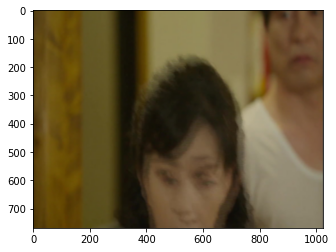

frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005140.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005148.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005156.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005164.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005172.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005180.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005188.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005196.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0045_IMAGE_0000005204.txt
frame.__len__6, mAP_file:AnotherMissOh07_004_0047_IMAGE_0000005251.txt


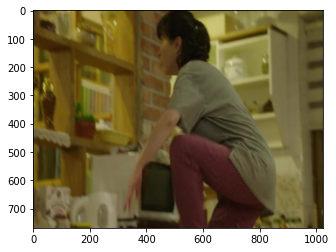

frame.__len__6, mAP_file:AnotherMissOh07_004_0047_IMAGE_0000005259.txt
frame.__len__6, mAP_file:AnotherMissOh07_004_0047_IMAGE_0000005267.txt
frame.__len__6, mAP_file:AnotherMissOh07_004_0047_IMAGE_0000005275.txt
frame.__len__6, mAP_file:AnotherMissOh07_004_0047_IMAGE_0000005283.txt
frame.__len__6, mAP_file:AnotherMissOh07_004_0047_IMAGE_0000005291.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005361.txt


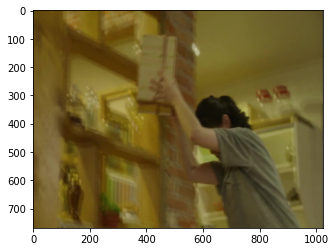

frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005369.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005377.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005385.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005393.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005401.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005409.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005417.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005425.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0048_IMAGE_0000005433.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005576.txt


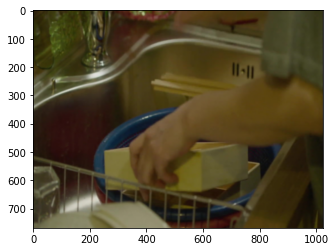

frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005584.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005592.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005600.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005608.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005616.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005624.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005632.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005640.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0050_IMAGE_0000005648.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005771.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



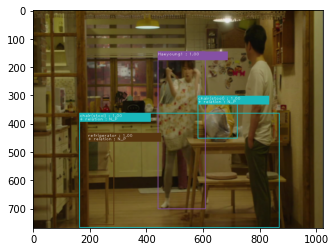

frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005779.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



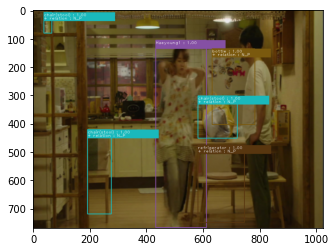

frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005787.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



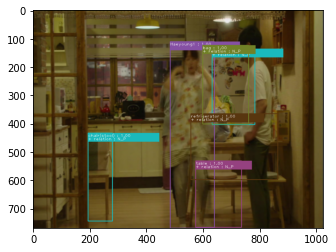

frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005795.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005803.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005811.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005819.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005827.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005835.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0051_IMAGE_0000005843.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005859.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



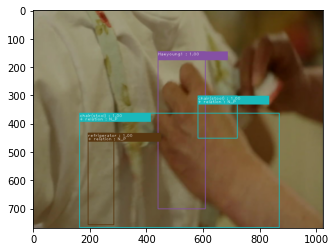

frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005867.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



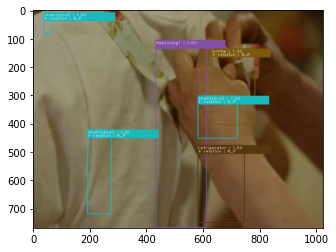

frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005875.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



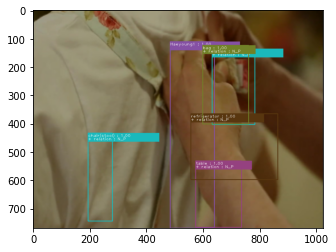

frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005883.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005891.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005899.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005907.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0052_IMAGE_0000005915.txt
frame.__len__3, mAP_file:AnotherMissOh07_004_0054_IMAGE_0000005985.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



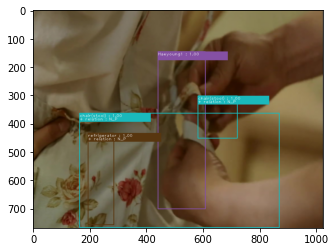

frame.__len__3, mAP_file:AnotherMissOh07_004_0054_IMAGE_0000005993.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



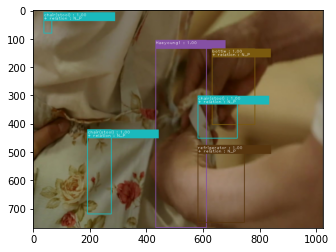

frame.__len__3, mAP_file:AnotherMissOh07_004_0054_IMAGE_0000006001.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



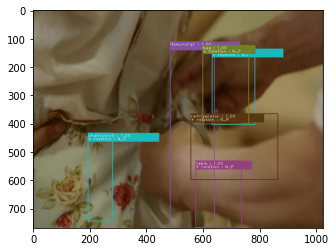

frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006037.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



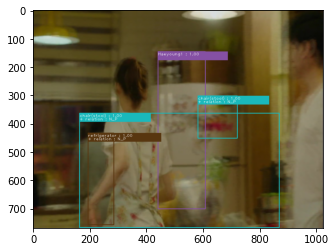

frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006045.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



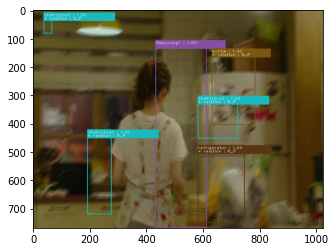

frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006053.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



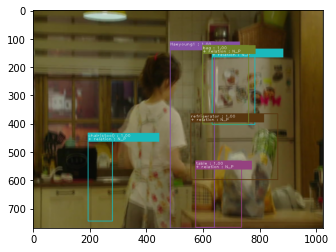

frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006061.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006069.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006077.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006085.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006093.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006101.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0055_IMAGE_0000006109.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006235.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



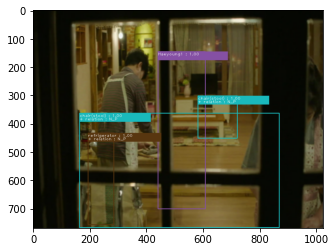

frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006243.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



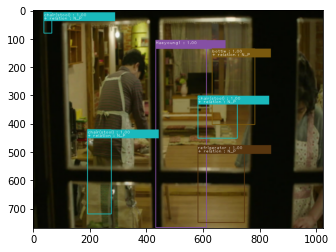

frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006251.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



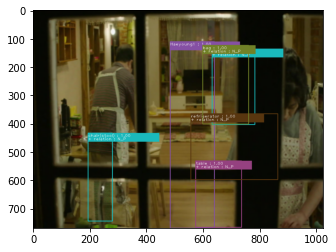

frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006259.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006267.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006275.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006283.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006291.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006299.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0056_IMAGE_0000006307.txt
frame.__len__2, mAP_file:AnotherMissOh07_004_0057_IMAGE_0000006314.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



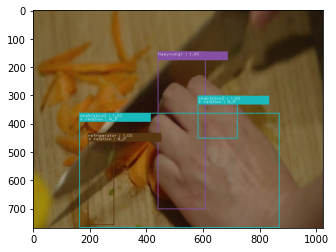

frame.__len__2, mAP_file:AnotherMissOh07_004_0057_IMAGE_0000006322.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



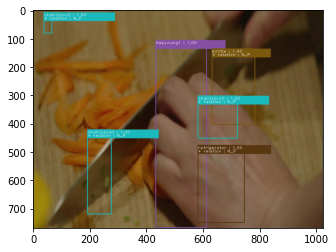

frame.__len__2, mAP_file:AnotherMissOh07_004_0058_IMAGE_0000006335.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



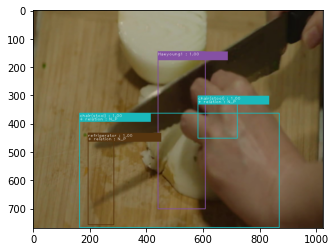

frame.__len__2, mAP_file:AnotherMissOh07_004_0058_IMAGE_0000006343.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



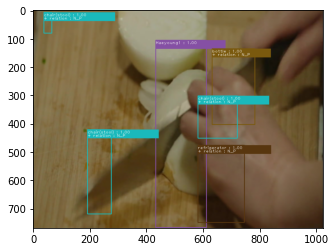

frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006372.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



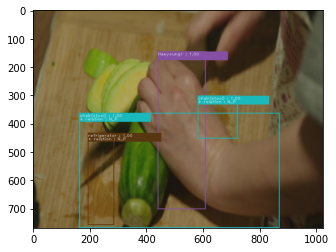

frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006380.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



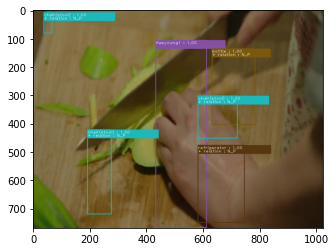

frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006388.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



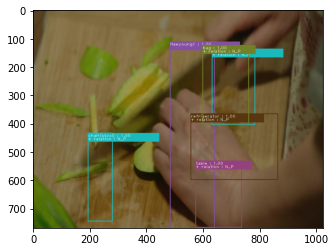

frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006396.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006404.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006412.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006420.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006428.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006436.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0059_IMAGE_0000006444.txt
frame.__len__2, mAP_file:AnotherMissOh07_004_0060_IMAGE_0000006459.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



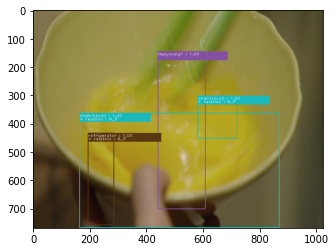

frame.__len__2, mAP_file:AnotherMissOh07_004_0060_IMAGE_0000006467.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



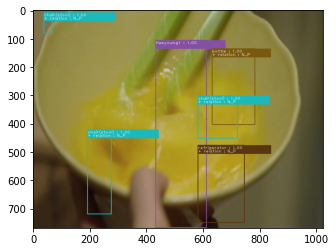

frame.__len__3, mAP_file:AnotherMissOh07_004_0061_IMAGE_0000006476.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



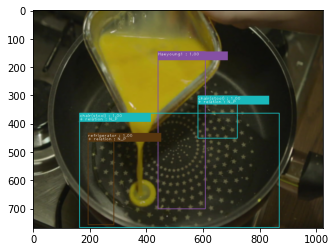

frame.__len__3, mAP_file:AnotherMissOh07_004_0061_IMAGE_0000006484.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



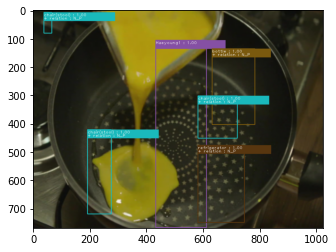

frame.__len__3, mAP_file:AnotherMissOh07_004_0061_IMAGE_0000006492.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



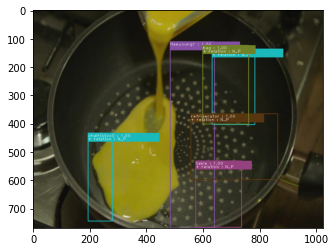

frame.__len__4, mAP_file:AnotherMissOh07_004_0062_IMAGE_0000006501.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



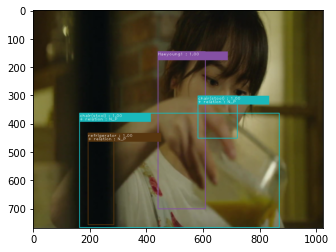

frame.__len__4, mAP_file:AnotherMissOh07_004_0062_IMAGE_0000006509.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



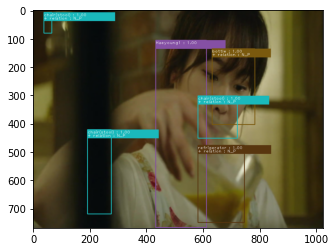

frame.__len__4, mAP_file:AnotherMissOh07_004_0062_IMAGE_0000006517.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



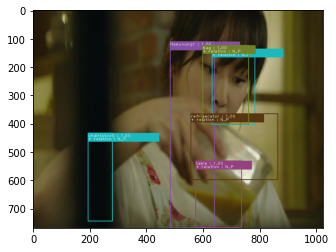

frame.__len__4, mAP_file:AnotherMissOh07_004_0062_IMAGE_0000006525.txt
frame.__len__3, mAP_file:AnotherMissOh07_004_0063_IMAGE_0000006535.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



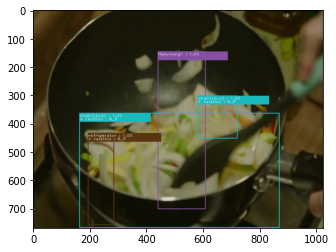

frame.__len__3, mAP_file:AnotherMissOh07_004_0063_IMAGE_0000006543.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



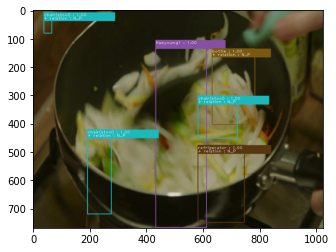

frame.__len__3, mAP_file:AnotherMissOh07_004_0063_IMAGE_0000006551.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



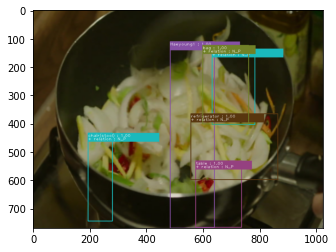

frame.__len__4, mAP_file:AnotherMissOh07_004_0064_IMAGE_0000006564.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



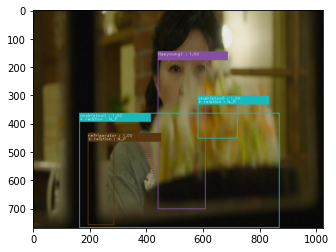

frame.__len__4, mAP_file:AnotherMissOh07_004_0064_IMAGE_0000006572.txt
frame.__len__4, mAP_file:AnotherMissOh07_004_0064_IMAGE_0000006580.txt
frame.__len__4, mAP_file:AnotherMissOh07_004_0064_IMAGE_0000006588.txt
frame.__len__3, mAP_file:AnotherMissOh07_004_0065_IMAGE_0000006600.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



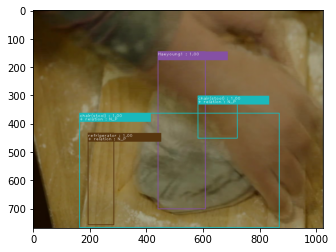

frame.__len__3, mAP_file:AnotherMissOh07_004_0065_IMAGE_0000006608.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



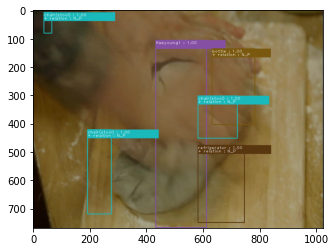

frame.__len__3, mAP_file:AnotherMissOh07_004_0065_IMAGE_0000006616.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



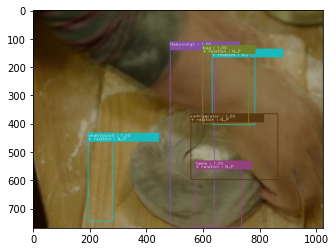

frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006625.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



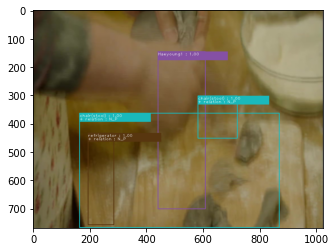

frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006633.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



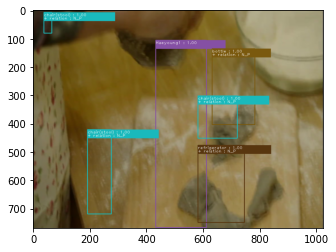

frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006641.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



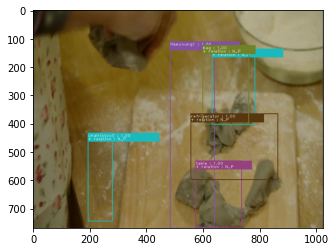

frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006649.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006657.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006665.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006673.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006681.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006689.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0066_IMAGE_0000006697.txt
frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006769.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



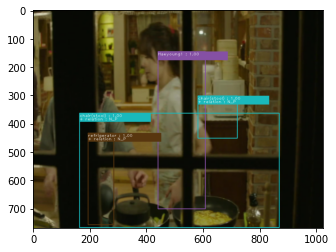

frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006777.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748

frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006785.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



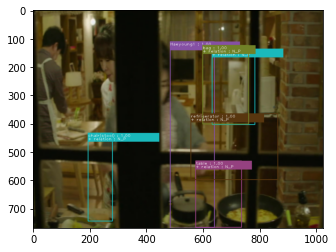

frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006793.txt
frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006801.txt
frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006809.txt
frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006817.txt
frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006825.txt
frame.__len__9, mAP_file:AnotherMissOh07_004_0068_IMAGE_0000006833.txt
frame.__len__3, mAP_file:AnotherMissOh07_004_0070_IMAGE_0000006862.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



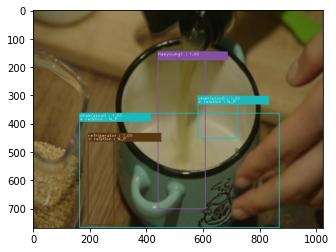

frame.__len__3, mAP_file:AnotherMissOh07_004_0070_IMAGE_0000006870.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



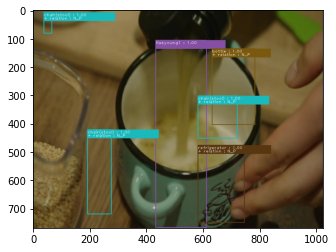

frame.__len__3, mAP_file:AnotherMissOh07_004_0070_IMAGE_0000006878.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



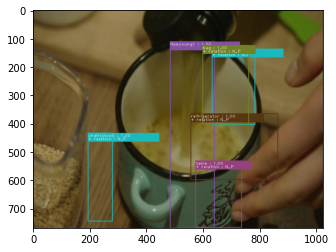

frame.__len__6, mAP_file:AnotherMissOh07_004_0071_IMAGE_0000006885.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



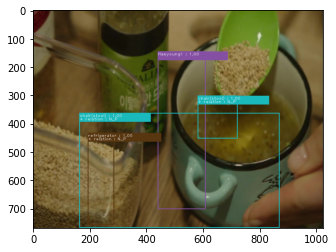

frame.__len__6, mAP_file:AnotherMissOh07_004_0071_IMAGE_0000006893.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



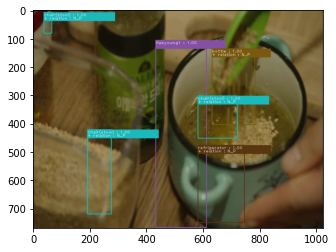

frame.__len__6, mAP_file:AnotherMissOh07_004_0071_IMAGE_0000006901.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



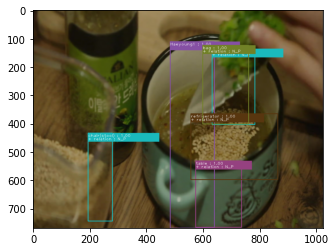

frame.__len__6, mAP_file:AnotherMissOh07_004_0071_IMAGE_0000006909.txt
frame.__len__6, mAP_file:AnotherMissOh07_004_0071_IMAGE_0000006917.txt
frame.__len__6, mAP_file:AnotherMissOh07_004_0071_IMAGE_0000006925.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006936.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



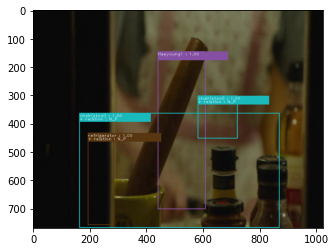

frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006944.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



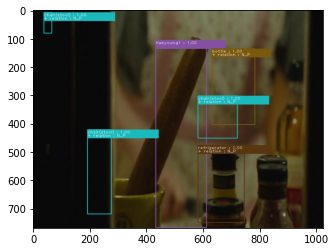

frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006952.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



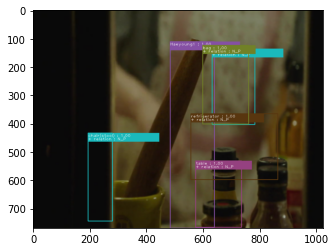

frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006960.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006968.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006976.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006984.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000006992.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000007000.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0072_IMAGE_0000007016.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007090.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



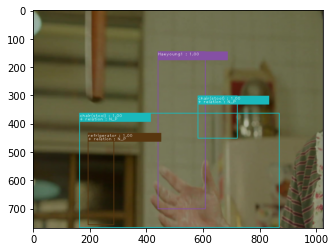

frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007098.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



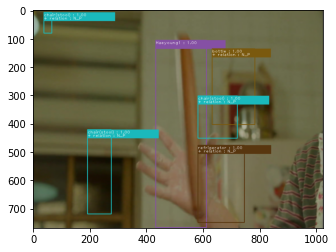

frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007106.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



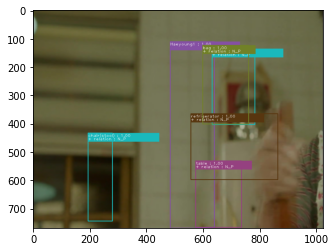

frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007114.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007122.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007130.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007138.txt
frame.__len__8, mAP_file:AnotherMissOh07_004_0073_IMAGE_0000007146.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007194.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



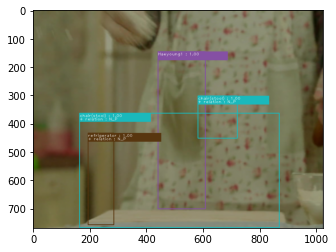

frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007202.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



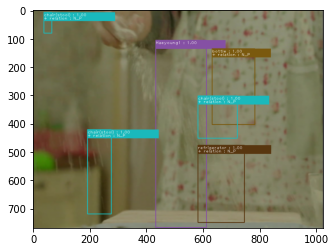

frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007210.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



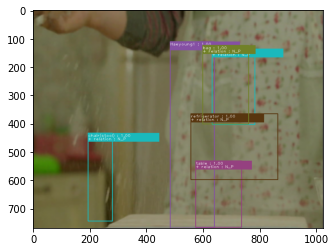

frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007218.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007226.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007242.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007250.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007258.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007266.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0075_IMAGE_0000007274.txt
frame.__len__5, mAP_file:AnotherMissOh07_004_0076_IMAGE_0000007340.txt
relation_pred:N_P 164 363 869 766

relation_pred:N_P 164 363 869 766

relation_pred:N_P 582 302 721 451

relation_pred:N_P 194 433 285 756



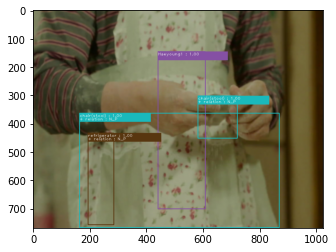

frame.__len__5, mAP_file:AnotherMissOh07_004_0076_IMAGE_0000007348.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 632 136 783 403

relation_pred:N_P 582 302 721 451

relation_pred:N_P 38 8 66 81

relation_pred:N_P 192 421 276 718

relation_pred:N_P 582 476 746 748



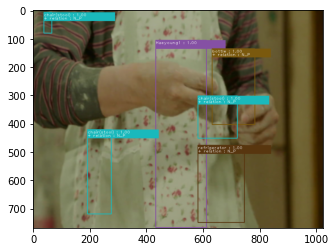

frame.__len__5, mAP_file:AnotherMissOh07_004_0076_IMAGE_0000007356.txt
relation_pred:N_P 632 136 783 403

relation_pred:N_P 194 433 280 743

relation_pred:N_P 574 531 736 765

relation_pred:N_P 557 365 864 597

relation_pred:N_P 599 124 761 401



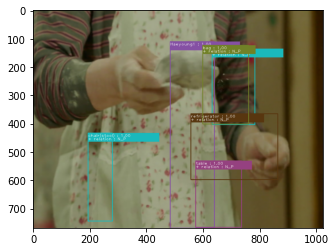

frame.__len__5, mAP_file:AnotherMissOh07_004_0076_IMAGE_0000007364.txt
frame.__len__5, mAP_file:AnotherMissOh07_004_0076_IMAGE_0000007372.txt
frame.__len__10, mAP_file:AnotherMissOh07_004_0077_IMAGE_0000007395.txt
relation_pred:N_P 262 365 298 458

relation_pred:N_P 222 481 303 562

relation_pred:N_P 101 463 215 549

relation_pred:N_P 3 473 348 766



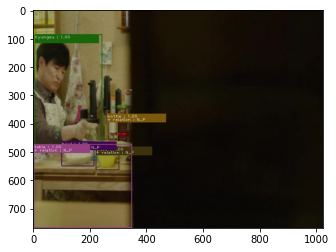

frame.__len__10, mAP_file:AnotherMissOh07_004_0077_IMAGE_0000007403.txt
relation_pred:N_P 280 365 318 464

relation_pred:N_P 378 318 424 458

relation_pred:N_P 365 0 393 58

relation_pred:N_P 240 473 321 552

relation_pred:N_P 121 463 240 549

relation_pred:N_P 0 479 476 698



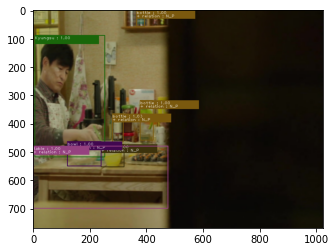

frame.__len__10, mAP_file:AnotherMissOh07_004_0077_IMAGE_0000007411.txt
relation_pred:N_P 297 365 333 464

relation_pred:N_P 383 318 429 454

relation_pred:N_P 385 0 411 58

relation_pred:N_P 335 365 381 461

relation_pred:N_P 443 413 489 476

relation_pred:N_P 260 470 346 549

relation_pred:N_P 146 481 257 542

relation_pred:N_P 260 461 399 537

relation_pred:N_P 26 461 555 680

relation_pred:N_P 297 365 333 464

relation_pred:N_P 383 318 429 454

relation_pred:N_P 385 0 411 58

relation_pred:N_P 335 365 381 461

relation_pred:N_P 443 413 489 476

relation_pred:N_P 260 470 346 549

relation_pred:N_P 146 481 257 542

relation_pred:N_P 260 461 399 537

relation_pred:N_P 26 461 555 680



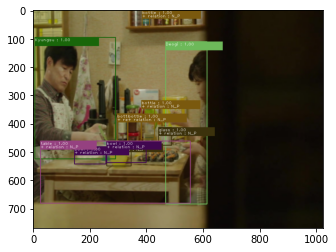

frame.__len__10, mAP_file:AnotherMissOh07_004_0077_IMAGE_0000007419.txt
relation_pred:N_P 315 365 348 461

relation_pred:N_P 413 318 459 457

relation_pred:N_P 287 338 315 452

relation_pred:N_P 476 408 512 466

relation_pred:N_P 277 470 361 552

relation_pred:N_P 167 476 271 544

relation_pred:N_P 272 467 391 549

relation_pred:N_P 36 467 587 690

relation_pred:N_P 315 365 348 461

relation_pred:N_P 413 318 459 457

relation_pred:N_P 287 338 315 452

relation_pred:N_P 476 408 512 466

relation_pred:N_P 277 470 361 552

relation_pred:N_P 167 476 271 544

relation_pred:N_P 272 467 391 549

relation_pred:N_P 36 467 587 690

relation_pred:N_P 315 365 348 461

relation_pred:N_P 413 318 459 457

relation_pred:N_P 287 338 315 452

relation_pred:N_P 476 408 512 466

relation_pred:N_P 277 470 361 552

relation_pred:N_P 167 476 271 544

relation_pred:N_P 272 467 391 549

relation_pred:N_P 36 467 587 690



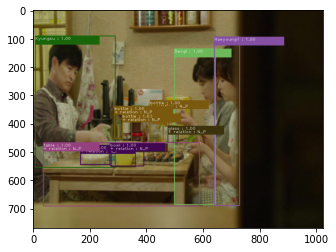

frame.__len__10, mAP_file:AnotherMissOh07_004_0077_IMAGE_0000007427.txt
relation_pred:N_P 323 373 356 469

relation_pred:N_P 423 325 469 464

relation_pred:N_P 297 343 325 457

relation_pred:N_P 476 408 512 466

relation_pred:N_P 310 485 394 567

relation_pred:N_P 184 473 288 542

relation_pred:N_P 272 467 391 549

relation_pred:N_P 36 467 587 690

relation_pred:N_P 323 373 356 469

relation_pred:N_P 423 325 469 464

relation_pred:N_P 297 343 325 457

relation_pred:N_P 476 408 512 466

relation_pred:N_P 310 485 394 567

relation_pred:N_P 184 473 288 542

relation_pred:N_P 272 467 391 549

relation_pred:N_P 36 467 587 690

relation_pred:N_P 323 373 356 469

relation_pred:N_P 423 325 469 464

relation_pred:N_P 297 343 325 457

relation_pred:N_P 476 408 512 466

relation_pred:N_P 310 485 394 567

relation_pred:N_P 184 473 288 542

relation_pred:N_P 272 467 391 549

relation_pred:N_P 36 467 587 690



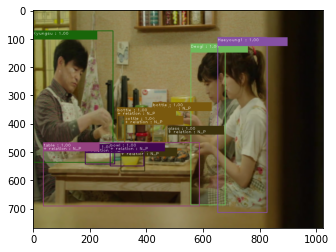

In [ ]:
# Sequence buffers
buffer_images = []
# load test clips
for iter, batch in enumerate(test_loader):
    image, info = batch

    # sort label info on fullrect
    image, label, behavior_label, obj_label, face_label, emo_label, frame_id = SortFullRect(
        image, info, is_train=False)

    try :
        image = torch.cat(image,0).cuda(device)
    except:
        continue

    # -----------------(2) inference -------------------------
    # object
    if np.array(obj_label).size > 0 :
        object_logits, _ = model_object(image)

        predictions_object = post_processing(object_logits,
                                             opt.image_size,
                                             ObjectCLS,
                                             model_object.detector.anchors,
                                             opt.conf_threshold,
                                             opt.nms_threshold)



    # relation
    if np.array(obj_label).size > 0 and np.array(label).size > 0:
        r_preds, r_obj_preds, relation_predictions = model_relation(image, label, obj_label)
    
    for idx, frame in enumerate(frame_id):

        # ---------------(3) mkdir for evaluations----------------------
        f_info = frame[0].split('/')
        save_dir = './results/drama-graph/{}/{}/{}/'.format(
            f_info[4], f_info[5], f_info[6])

        f_file = f_info[7]
        mAP_file = "{}_{}_{}_{}".format(f_info[4],
                                        f_info[5],
                                        f_info[6],
                                        f_info[7].replace("jpg", "txt"))
        if opt.display:
            print("frame.__len__{}, mAP_file:{}".format(len(frame_id), mAP_file))
            
        # --------------(5) visualization of inferences ----------
        # out of try : pdb.set_trace = lambda : None
        try:
            # for some empty video clips
            img = image[idx]
            # ToTensor function normalizes image pixel values into [0,1]
            np_img = img.cpu().numpy()
            np_img = np.transpose(np_img,(1,2,0)) * 255
            output_image = cv2.cvtColor(np_img,cv2.COLOR_RGB2BGR)
            output_image = cv2.resize(output_image, (width, height))

            # object
            if len(predictions_object) != 0:
                prediction_object = predictions_object[0]
                num_preds = len(prediction)
                for jdx, pred in enumerate(prediction_object):
                    xmin = int(max(pred[0] / width_ratio, 0))
                    ymin = int(max(pred[1] / height_ratio, 0))
                    xmax = int(min((pred[2]) / width_ratio, width))
                    ymax = int(min((pred[3]) / height_ratio, height))
                    color = colors[ObjectCLS.index(pred[5])]

                    cv2.rectangle(output_image, (xmin, ymin),
                                  (xmax, ymax), color, 2)

                    text_size = cv2.getTextSize(
                        pred[5] + ' : %.2f' % pred[4],
                        cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                    cv2.rectangle(
                        output_image,
                        (xmin, ymin),
                        (xmin + text_size[0] + 100,
                         ymin + text_size[1] + 20), color, -1)
                    cv2.putText(
                        output_image, pred[5] + ' : %.2f' % pred[4],
                        (xmin, ymin + text_size[1] + 4),
                        cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)

                    # save detection results
                    pred_cls = pred[5]
                    cat_pred = '%s %s %s %s %s %s\n' % (
                        pred_cls,
                        str(pred[4]),
                        str(xmin), str(ymin), str(xmax), str(ymax))

                    print("object_pred:{}".format(cat_pred))

                    if opt.display:
                        print("detected {}".format(
                            save_dir + "{}".format(f_file)))
                else:
                    if opt.display:
                        print("non-detected {}".format(
                        save_dir + "{}".format(f_file)))
                        
            # relation
            if len(r_preds) != 0:
                r_pred = r_preds[idx]
                r_obj_pred = r_obj_preds[idx]
                relation_prediction = relation_predictions[idx]
                num_preds = len(r_pred)
                for jdx, pred in enumerate(r_pred):
                    xmin = int(max(float(pred[0]) / width_ratio, 0))
                    ymin = int(max(float(pred[1]) / height_ratio, 0))
                    xmax = int(min((float(pred[2])) / width_ratio, width))
                    ymax = int(min((float(pred[3])) / height_ratio, height))
                    color = colors[PersonCLS.index(pred[5])]

                    cv2.rectangle(output_image, (xmin, ymin),
                                  (xmax, ymax), color, 2)

                    text_size = cv2.getTextSize(
                        pred[5] + ' : %.2f' % float(pred[4]),
                        cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                    cv2.rectangle(
                        output_image,
                        (xmin, ymin),
                        (xmin + text_size[0] + 100,
                         ymin + text_size[1] + 20), color, -1)
                    cv2.putText(
                        output_image, pred[5] + ' : %.2f' % float(pred[4]),
                        (xmin, ymin + text_size[1] + 4),
                        cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)

                    for kdx, obj_pred in enumerate(r_obj_pred):
                        xmin = int(max(float(obj_pred[0]) / width_ratio, 0))
                        ymin = int(max(float(obj_pred[1]) / height_ratio, 0))
                        xmax = int(min((float(obj_pred[2])) / width_ratio, width))
                        ymax = int(min((float(obj_pred[3])) / height_ratio, height))

                        color = colors[ObjectCLS.index(obj_pred[5])]

                        cv2.rectangle(output_image, (xmin, ymin),
                                      (xmax, ymax), color, 2)
                        
                        text_size = cv2.getTextSize(
                            obj_pred[5] + ' : %.2f' % float(obj_pred[4]),
                            cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
                        cv2.rectangle(
                            output_image,
                            (xmin, ymin),
                            (xmin + text_size[0] + 100,
                             ymin + text_size[1] + 20), color, -1)
                        cv2.putText(
                            output_image, obj_pred[5] + ' : %.2f' % float(obj_pred[4]),
                            (xmin, ymin + text_size[1] + 4),
                            cv2.FONT_HERSHEY_PLAIN, 1,
                            (255, 255, 255), 1)

                        value, ind = relation_prediction[kdx].max(1)
                        ind = int(ind.cpu().numpy())
                        rel_ind = P2ORelCLS[ind]
                        cv2.putText(
                            output_image, '+ relation : ' + rel_ind,
                            (xmin, ymin + text_size[1] + 4 + 12),
                            cv2.FONT_HERSHEY_PLAIN, 1,
                            (255, 255, 255), 1)

                        pred_cls = rel_ind
                        cat_pred = '%s %s %s %s %s\n' % (
                            pred_cls, str(xmin), str(ymin), str(xmax), str(ymax))
                        print("relation_pred:{}".format(cat_pred))
                        
            # save output image  
            cv2.imwrite(save_dir + "{}".format(f_file), output_image)
            # save images
            plt_output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
            plt.imshow(plt_output_image.astype('uint8'))
            plt.show()
            plt.close()
        except:
            continue

In [ ]:
        # --------------(4) ground truth ---------------------------------
        # save person ground truth
        gt_person_cnt = 0
        if len(label) > idx :
            # person
            for det in label[idx]:
                cls = PersonCLS[int(det[4])]
                xmin = str(max(det[0] / width_ratio, 0))
                ymin = str(max(det[1] / height_ratio, 0))
                xmax = str(min((det[2]) / width_ratio, width))
                ymax = str(min((det[3]) / height_ratio, height))
                cat_det = '%s %s %s %s %s\n' % (cls, xmin, ymin, xmax, ymax)
                if opt.display:
                    print("person_gt:{}".format(cat_det))
                gt_person_cnt += 1
                
            # behavior
            for j, det in enumerate(label[idx]):
                cls = PBeHavCLS[int(behavior_label[idx][j])].replace(' ', '_')
                if cls == 'none':
                    continue

                cls = cls.replace('/', '_')
                xmin = str(max(det[0] / width_ratio, 0))
                ymin = str(max(det[1] / height_ratio, 0))
                xmax = str(min((det[2]) / width_ratio, width))
                ymax = str(min((det[3]) / height_ratio, height))
                cat_det = '%s %s %s %s %s\n' % (cls, xmin, ymin, xmax, ymax)
                if opt.display:
                    print("behavior_gt:{}".format(cat_det))
        # object
        gt_object_cnt = 0
        if len(obj_label) > idx :
            for det in obj_label[idx]:
                cls = ObjectCLS[int(det[4])]
                xmin = str(max(det[0] / width_ratio, 0))
                ymin = str(max(det[1] / height_ratio, 0))
                xmax = str(min((det[2]) / width_ratio, width))
                ymax = str(min((det[3]) / height_ratio, height))
                cat_det = '%s %s %s %s %s\n' % (cls, xmin, ymin, xmax, ymax)
                if opt.display:
                    print("object_gt:{}".format(cat_det))
                gt_object_cnt += 1
                
        # relation
        gt_relation_cnt = 0
        if len(obj_label) > idx:
            for det in obj_label[idx]:
                cls = P2ORelCLS[int(det[5])]
                xmin = str(max(det[0] / width_ratio, 0))
                ymin = str(max(det[1] / height_ratio, 0))
                xmax = str(min((det[2]) / width_ratio, width))
                ymax = str(min((det[3]) / height_ratio, height))
                cat_det = '%s %s %s %s %s\n' % (cls, xmin, ymin, xmax, ymax)
                if opt.display:
                    print("relation_gt:{}".format(cat_det))
                gt_relation_cnt += 1

        # place
        if len(preds_place_txt) > idx:
            if opt.display:
                print("place_gt:{}".format(target_place_txt[idx]))
        # face
        gt_face_cnt = 0
        if len(face_label) > idx:
            for det in face_label[idx]:
                cls = PersonCLS[int(det[4])]
                xmin = str(max(det[0] / width_ratio, 0))
                ymin = str(max(det[1] / height_ratio, 0))
                xmax = str(min((det[2]) / width_ratio, width))
                ymax = str(min((det[3]) / height_ratio, height))
                cat_det = '%s %s %s %s %s\n' % (cls, xmin, ymin, xmax, ymax)
                print("face_gt:{}".format(cat_det))
                gt_face_cnt += 1